<p>This notebook demonstrates an implementation Singular Spectrum Analysis (SSA) in Python. SSA is a technique which applies the method of Principal Component Analysis to time series data. It's well suited for analysing short and noisy time series without relying on prior information about the evolution equations governing the process. Applications include prediction, noise reduction, detecting trends and periodicities.</p> 
<p>I'll closely follow Vautard, Yiou and Ghil (1992). Their article offers an overview of SSA, explores certain aspects in detail and provides several aplications. Here I'll demonstrate how SSA can be used for <b>noise reduction</b> and <b>trend analysis</b>, using simulated data and an IPCC global average temperature series.</p>

In [3]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy.random as random 
import pandas as pd
import math
from concurrent.futures import ProcessPoolExecutor, wait, as_completed
from SSA import SSA

<h2>Principal Components</h2>
<p>As with PCA, we begin by computing a covariance matrix. But in this case it will be the autocovariance $c(j)$ of the series for lags $0 \leq j \leq M-1$. The covariances are arranged in an $M \times M$ matrix as below, with the values on each diagonal being the autocovariance at a certain lag.</p>

$^{T_{x}}=\begin{bmatrix}
c(0) &  c(1) & . & . & . & c(M-1)\\ 
c(1) & c(0) & c(1) &  &  & .\\ 
. & c(1) & . & . &  & .\\ 
. &  &  & . & . & .\\ 
. &  &  & . & . & .\\ 
c(M-1) & . & . & . & c(1) & c(0)
\end{bmatrix}$

A matrix with constant values on the descending diagonals is known as a Toeplitz matrix, and with this method it will also be symmetric. In contrast with PCA where $M$ is ascribed as the dimensionality of the data, in SSA it's determined by our choice of window length. (Choosing an appropriate $M$ is a problem in itself, which I won't look at here.)

We create $T_{x}$ as follows,
```Python
def _compute_t_matrix(self):
    n = self.n
    m = self.m
    data = self.data
    covariances = [(1 / (n - j)) * np.matmul(data.T[0, 0:n - j - 1],
                                             data[j:n - 1, 0]) for j in range(m)]
    toeplitz_matrix = np.array([covariances[abs(p - q)]
                                for p, q in
                                it.product(*([range(m)] * 2))]).reshape((m, m))
    self.t_matrix = toeplitz_matrix
```
<p>The autocovariance lag for a cell in $T_{x}$ depends on how far it is from the main diagonal. We iterate through every pair of indices $p,q$, populating these values to end up with an $M*M \times 1$ array which we reshape into an $M \times M$ matrix. To illustrate using simulated data with two oscillations and a white noise component,</p>

In [4]:
def generate_process(sigma, seed=0):
    np.random.seed(seed)
    om1 = (2/20)*np.pi
    om2 = (2/7)*np.pi
    phi1 = random.random()*2*np.pi
    phi2 = random.random()*2*np.pi
    y1 = [2*np.cos(om1*n+phi1) + np.cos(om2+phi2) for n in range(150)]
    w1 = random.normal(0, sigma, 150)
    return y1+w1

In [5]:
lags = 40
p1 = generate_process(2.5)
ssa = SSA(data=p1, m=lags)

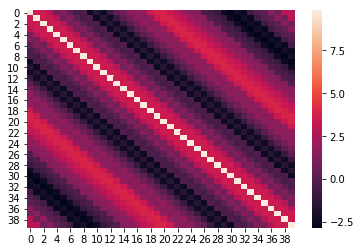

In [6]:
ax = sns.heatmap(ssa.t_matrix)
plt.show() 

<p>The next step is to find the eigenvalues and eigenvectors of $T_{x}$ in order to find the Principal Components (PCs). Since $T_{x}$ is symmetric, we can use numpy.linalg.eigh for hermitian matrices. The eigenvectors form an orthonormal basis. Just as with PCA, the first few basis vectors with the highest eigenvalues will account for most of the variance.

From the plot we can see the eigenvalues after the third drop sharply in value. If we were looking to remove noise from the series, we'd have a clear choice of PCs. Below I'll illustrate Vautard, Yiou and Ghil's algorithm for when the choice is not so clear.

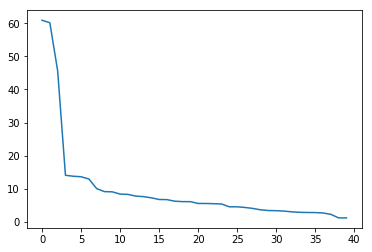

In [7]:
plt.plot([e["value"] for e in ssa.eigs])

<p>The $k^{th}$ PC is computed as</p>
<p>$a_{i}^{k}=\sum_{j=1}^{M}x_{i+j}E_{j}^{k}, 0\leq i\leq N-M$</p>

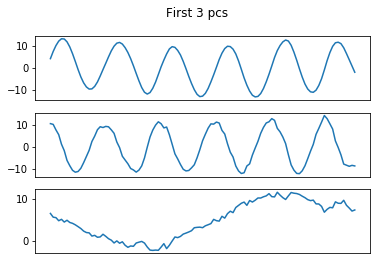

In [8]:
fig, axs = plt.subplots(3)
fig.suptitle('First 3 pcs')
for i in range(3):
    axs[i].set_xticks([])
    axs[i].plot(ssa.pcs[i])

<h2>Reconstructed Components</h2>
<p>By analogy with PCA, the reconstruction of the series from a subset $A$ of the eigenelements would be,</p>
<p>$x_{i+j}=\sum_{k=1}^{M}a_{i}^{k}E_{j}^{k}, 1\leq j\leq M$</p>
<p>For a given (data point) in the original series, there are up to $M$ different reconstructions corresponding to different values of $i$ and $j$. Vautard, Yiou and Ghil propose a method for computing a series of reconstructed components (RCs) designed to minimise,</p>
<p>$H_{A}(y)=\sum_{i=0}^{N-M}\sum_{j=1}^{M}\left (y_{i+j}-\sum_{k\in A}a_{i}^{k}E_{j}^{k}\right )^{2}$</p>
<p>If we imagine turning the original series into an 'augmented series',</p>
<p>
$\begin{bmatrix}
x_1 & x_2 & ... & x_{N-M}\\ 
x_2  & x_3  & ... & x_{N-M+1}\\ 
\vdots & & & \ddots & \\
x_M & x_{M+1} & ... & x_N
\end{bmatrix}$
</p>    
<p>then the aim is to minimise the difference between the reconstructed series $y_{i+j}$ and the projection of the augmented series onto the *basis spanned by $A$ (check terminology)*. This a least squares problem, solved by taking the average of the different reconstructions for a given (data point):</p>
<p>$(R_{A}x)_{i}=\frac{1}{i}\sum_{j=1}^{i}\sum_{k\in A}a_{i-j}^{k}E_{j}^{k}$, for $0\leq i\leq M-1$ (points near the beginning of the series)</p>
<p>$(R_{A}x)_{i}=\frac{1}{i}\sum_{j=i-N+M}^{M}\sum_{k\in A}a_{i-j}^{k}E_{j}^{k}$, for $N-M+2\leq i\leq N$ (points near the end of the series)</p>
<p>$(R_{A}x)_{i}=\frac{1}{M}\sum_{k=1}^{M}\sum_{k\in A}a_{i-j}^{k}E_{j}^{k}$ for $M\leq i\leq N-M+1$ (All other points)</p>

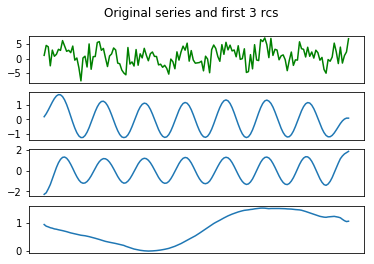

In [9]:
fig, axs = plt.subplots(4)
fig.suptitle('Original series and first 3 rcs')
axs[0].set_xticks([])
axs[0].plot(ssa.data, color="green")
for i in range(3):
    axs[i+1].set_xticks([])
    axs[i+1].plot(ssa.get_rcs(subset=[i]))

<h2> Noise Reduction Algorithm</h2>
<p>Vautard, Yiou and Ghil provide an algorithm for finding the significant PCs, allowing us to separate out the clean and noisy components. Given the subsets of indices,</p>
<p>
$A : \left \{ 1, ..., p \right \}$
<br>$A' : \left \{p+1, ..., M \right \}$
</p>
<p> the goal is to find the order $p$ where $R_{A}x$ is the significant part of the signal, and $R_{A'}x$ the noise. The algorithm works by comparing $R_{A'}x$ with $R_{A'}\upsilon$, a reconstruction of the white noise series $\upsilon$ using the same subset of eigenelements.
</p>
<p>
It proceeds as follows. First generate 100 realisations of a gaussian white noise process $\upsilon$. Then for $p=1 ... M$,
</p>
<p>
• For each lag $0\leq j \leq M$, find the compute the autocovariance $c_{p}(j)$ of $R_{A'}x$.
</p>
<p>
• For each lag $0\leq j \leq M$, find the compute confidence intervals $(c_{-}(j),c_{+}(j))$ for the autocovariance of $R_{A'}\upsilon$.
</p>
<p>
• For lags $0\leq j \leq M$ we have $M$ noise intervals. Try to find a real positive number $\beta$ such that $\beta c_{-}(j) \leq c_{p}(j) \leq \beta c_{+}(j)$ There are 3 possibilities here:
<ul style="list-style-type: circle;">
<li>If $c_{-}(j)$ is negative and $c_{+}(j)$ is positive, $\beta $ needs to be large enough such that $\beta c_{-}(j) \leq c_{p}(j)$ and $c_{p}(j) \leq \beta c_{+}(j)$. The greatest of these two lower limits will be the lower bound on $\beta $. There is no upper bound on how large $\beta $ can be.</li>
<li>If $c_{-}(j)$ and $c_{+}(j)$ are both positive, $\beta $ needs to be small enough such that $\beta c_{-}(j) \leq c_{p}(j)$ and large enough that $c_{p}(j) \leq \beta c_{+}(j)$</li>
<li>If $c_{-}(j)$ and $c_{+}(j)$ are both negative, $\beta $ needs to be large enough such that $\beta c_{-}(j) \leq c_{p}(j)$ and small enough that $c_{p}(j) \leq \beta c_{+}(j)$</li>
</ul>
</p>
<p>
We can see that at each $j$ there will be bounds on the value of $\beta $. If a $\beta $ exists for a given order it will lie in the intersection of these M intervals. The possible values of $\beta $ themselves form an interval, $(\gamma_{p}, \delta_{p})$. If this interval is non-empty, $R_{A'}x$ isn't statistically distinguishable from a reconstruction of white noise and the algorithm terminates. $p$ gives the index of the last significant eigenelement.
</p>

We use concurrent.futures.ProcessPoolExecutor to generate white noise series in parallel. The plot shows the intervals $(\beta c_{-}(j),\beta c_{+}(j))$ and the correlation $c_{p}(j)$ which is just within each interval.

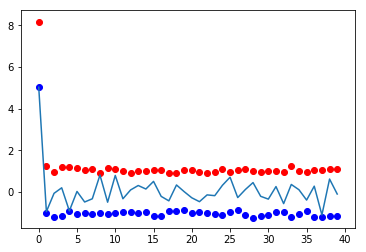

In [10]:
with ProcessPoolExecutor() as executor:
            v_futures = [executor.submit(ssa._generate_white_noise, i) for i in range(100)]
v = [f.result() for f in wait(v_futures).done]
        
eigs = ssa.eigs
m = ssa.m
n = ssa.n
        
for p in range(0, len(eigs) - 1):
    # For a given order p, we reconstruct with subset of eigenvectors p+1... m
    subset = list(range(p + 1, m))
    noise_intervals = ssa._get_noise_intervals(v, subset)
    rcs = ssa.get_rcs(subset)
    c_ps = [(1 / (n - j)) * np.matmul(rcs[0:n - j - 1],
                                      rcs[j:n - 1]) for j in range(m)]
    beta_intervals = [ssa.get_beta_interval(c_p, noise_interval) 
                      for c_p, noise_interval in zip(c_ps, noise_intervals)]
    delta = np.amax([beta_interval[0] for beta_interval in beta_intervals], axis=0)
    gamma = np.amin([beta_interval[1] for beta_interval in beta_intervals], axis=0)
    if delta <= gamma:
        beta_value = (delta + gamma)/2
        plt.scatter(range(m), np.multiply(beta_value, [noise_interval[0] for
                                             noise_interval in noise_intervals]), color="blue")
        plt.scatter(range(m), np.multiply(beta_value, [noise_interval[1]
                                                      for noise_interval in noise_intervals]), color="red")
        plt.plot(c_ps)
        order = p
        break

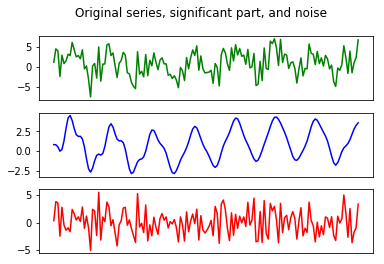

In [11]:
fig, axs = plt.subplots(3)
fig.suptitle('Original series, significant part, and noise')
axs[0].set_xticks([])
axs[0].plot(ssa.data, color="green")
axs[1].set_xticks([])
axs[1].plot(ssa.get_rcs(list(range(order + 1))), color="blue")
axs[2].set_xticks([])
axs[2].plot(ssa.get_rcs(list(range(order + 1, m))), color="red")

<h2>Trend Detection</h2>
<p>Finally we look at Vautard, Yiou and Ghil's algorithm for detecting a trend using the Kendall test. (Reference) Look at pairs of data points $(x_i, x_j), i < j$ and find the number $K_r$ of pairs where $x_i < x_j$. A high value of $K_r$ indicates a positive trend, whereas a low value indicates a negative trend. The test statistic is,
<p>
$\tau =\frac{4K_{r}}{n(n-1)}-1$
</p>
<p> Which has an expected value of zero under the null hypothesis of no trend, with standard deviation,
<p>
$s=\sqrt{\frac{2(2n+5)}{9n(n-1)}}$
</p>
<p>
Given the premise that a significant trend should appear in the first few PCs, we iterate through these looking for the first PC such that we don't reject the null hypothesis. The PCs following that represent the detrended series.

In [10]:
def detrend_series(x, m):
    trend = True
    n = len(x) - m + 1  # why n - m + 1
    while trend:
        ssa = SSA(data=x, m=m)
        for order, pc in enumerate(ssa.pcs):
            k_r = 0
            for j in range(1, n):
                k_r += sum([1 for i in range(j) if pc[i] < pc[j]])
            tau = (4*k_r)/(n*(n-1)) - 1
            s = math.sqrt(2*(2*n + 5)/(9*n*(n - 1)))
            if -1.96*s <= tau <= 1.96*s:
                detrended = ssa.get_rcs(range(order, m))
                return order, detrended
            if order == m - 1:
                # Unable to find pc without trend
                return None

The plot below shows the result of a trend analysis performed on IPCC Global mean temperature from 1901 to 2000, from Smith, T. M., and R. W. Reynolds (2005).

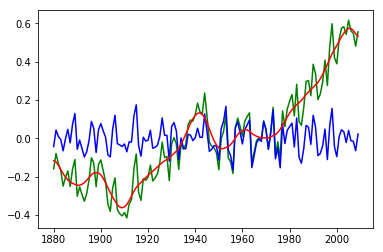

In [11]:
ipcc_data = pd.read_csv("ipcc_data.csv")
plt.plot(ipcc_data["YEAR"].tolist(), ipcc_data["GLOBAL_AVG_TEMP"], color="green")
order, detrended = detrend_series(ipcc_data["GLOBAL_AVG_TEMP"], 20)
plt.plot(ipcc_data["YEAR"].tolist(), detrended, color="blue")
trend = SSA(data=ipcc_data["GLOBAL_AVG_TEMP"].tolist(), m=20).get_rcs(range(order))
plt.plot(ipcc_data["YEAR"].tolist(), trend, color="red")

<h2>References</h2>
<p>
Smith, T. M., and R. W. Reynolds (2005), A global merged land air and sea surface temperature reconstruction based on historical observations (1880-1997), J. Climate, 18, 2021-2036.
</p>
<p>
Vautard, R & Yiou, P. & Ghil, Michael. (1992). Singular-spectrum analysis: A toolkit for short, noisy chaotic signals. Physica D-nonlinear Phenomena - PHYSICA D. 58. 95-126.
</p>

<h2>Python Implementation</h2>


```Python
import numpy as np
import itertools as it
from concurrent.futures import ProcessPoolExecutor, wait, as_completed

class SSA(object):
    t_matrix = None
    eigs = None
    pcs = None
    rcs = None

    def __init__(self, data, m):
        self.data = np.array(data)
        self.m = m
        self.n = len(self.data)
        self.data = self.data.reshape((self.n, 1))
        self._compute_t_matrix()
        self._compute_eigs()
        self._compute_pcs()

    def _compute_t_matrix(self):
        n = self.n
        m = self.m
        data = self.data
        covariances = [(1 / (n - j)) * np.matmul(data.T[0, 0:n - j - 1], data[j:n - 1, 0]) for j in range(m)]
        toeplitz_matrix = np.array([covariances[abs(i - j)]
                                    for i, j in it.product(*([range(m)] * 2))]).reshape((m, m))
        self.t_matrix = toeplitz_matrix

    def _compute_eigs(self):
        eig_values, eig_vectors = np.linalg.eigh(self.t_matrix)
        eigs = [{"value": value, "vector": vector} for value, vector in
                zip(eig_values, list(eig_vectors.T))]
        eigs_sorted = sorted(eigs, key=lambda e: e["value"],
                             reverse=True)  # Sort eigenvalues and eigenvectors by descending eigenvalue
        self.eigs = eigs_sorted

    def _compute_pcs(self):
        k = 0
        n = self.n
        m = self.m
        eigs = self.eigs
        pcs = np.vstack([[np.matmul(self.data[i:i + m, 0], eigs[k]["vector"]) for i in range(n - m + 1)]
                         for k in range(len(eigs))])
        self.pcs = pcs

    def get_rcs(self, subset):
        m = self.m
        n = self.n
        pcs = self.pcs
        eigs = self.eigs
        rcs = []
        for i in range(1, n + 1):
            s = 0
            rc = (1 / len(self._get_pc_window(i))) * sum(
                [np.matmul(pcs[s][self._get_pc_window(i)].T, eigs[s]["vector"][self._get_eig_window(i)])
                 for s in subset])
            rcs.append(rc)
        return rcs

    def _get_pc_window(self, i):
        m = self.m
        n = self.n
        if 1 <= i <= m - 1:
            return range(i - 1, -1, -1)  # close to beginning: from (i - 1)th pc to zeroth pc (descending)
        elif n - m + 2 <= i <= n:
            return range(n - m, i - m - 1, -1)  # close to end: from (n - m)th pc to (i - m)th pc (descending).
        else:
            return range(i - 1, i - m - 1, -1) # 

    def _get_eig_window(self, i):
        m = self.m
        n = self.n
        if 0 <= i <= m - 1:
            return range(0, i)  # close to beginning of series
        elif n - m + 2 <= i <= n:
            return range(i - n + m - 1, m)  # close to end of series
        else:
            return range(0, m)

    def find_statistical_order(self):
        eigs = self.eigs
        m = self.m
        n = self.n
        
        # Generate 100 white noise processes
        with ProcessPoolExecutor() as executor:
            v_futures = [executor.submit(self._generate_white_noise, i) for i in range(100)]
        v = [f.result() for f in wait(v_futures).done]
        
        for p in range(0, len(eigs) - 1):
            # For a given order p, we reconstruct with subset of eigenvectors p+1... m
            subset = list(range(p + 1, m))
            noise_intervals = self._get_noise_intervals(v, subset)
            rcs = self.get_rcs(subset)
            c_ps = [(1 / (n - j)) * np.matmul(rcs[0:n - j - 1],
                                              rcs[j:n - 1]) for j in range(m)]
            beta_intervals = [self.get_beta_interval(c_p, noise_interval) for c_p, noise_interval in zip(c_ps, noise_intervals)]
            delta = np.amax([beta_interval[0] for beta_interval in beta_intervals], axis=0)
            gamma = np.amin([beta_interval[1] for beta_interval in beta_intervals], axis=0)
            if delta <= gamma:
                return p, (delta, gamma)
        return -1, None

    def _get_noise_intervals(self, v, subset):
        m = self.m
        n = self.n
        c_ws = []
        with ProcessPoolExecutor() as executor:
            c_ws = list(executor.map(self._get_noise_correlations, v, [subset]*len(v)))
        means, sems = np.mean(c_ws, axis=0), np.var(c_ws, axis=0)
        noise_intervals = [(mean-1.96*(var**0.5), mean+1.96*(var**0.5)) for mean, var in zip(means, sems)]
        return noise_intervals

    def _get_noise_correlations(self, w_ssa, subset):
        m = self.m
        n = self.n
        rc_w = w_ssa.get_rcs(subset)
        c_w = [(1 / (n - j)) * np.matmul(rc_w[0:n - j - 1],
                                         rc_w[j:n - 1]) for j in range(m)]
        return c_w

    def get_beta_interval(self, c_p, noise_interval):
        # If lower bound is negative and upper bound is positive, there's no upper
        # limit on beta
        if noise_interval[0] < 0 < noise_interval[1]:
            return max(c_p / noise_interval[0], c_p / noise_interval[1]), np.inf

        # If both lower bound and upper bound are positive: beta must be small enough
        # that c_p is greater than lower bound, large enough that c_p is less than
        # upper bound
        elif 0 < noise_interval[0] < noise_interval[1]:
            return c_p / noise_interval[1], c_p / noise_interval[0]

        # If both lower bound and upper bound are negative, beta must be large enough
        # that c_p is greater than lower bound, small enough that c_p is less than
        # upper bound
        elif noise_interval[0] < noise_interval[1] < 0:
            return c_p / noise_interval[0], c_p / noise_interval[1]

        elif noise_interval[0] == 0 or noise_interval[1] == 0:
            # if lower bound negative, beta must be large enough that c_p greater
            # than negative lower bound
            if noise_interval[0] < 0:
                return c_p / noise_interval[0], np.inf
            # if upper bound positive, beta must be large enough that c_p less than
            # upper bound
            elif noise_interval[1] > 0:
                return c_p / noise_interval[1], np.inf

        else:
            return np.nan, np.nan

    def _generate_white_noise(self, seed):
        np.random.seed(seed)
        w_ssa = SSA(data=np.random.normal(0, 1, self.n), m=self.m)
        return w_ssa

```